<a href="https://colab.research.google.com/github/PaulVanDev/HoeffdingD/blob/master/EfficientHoeffdingD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from scipy.signal import decimate
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Direct transcription of Matlab code / Used as reference

References:
matlab code

https://stackoverflow.com/questions/9270496/ideas-for-gpu-implementation-of-hoeffdings-d-dependence-coefficient/9322657#9322657

HoeffdingD formule

http://support.sas.com/documentation/cdl/en/procstat/63104/HTML/default/viewer.htm#procstat_corr_sect016.htm

In [0]:
# Direct transcription of R code / Used as reference
def hoeffdingsD( x, y ):

    #N = size(x,1);
    N=x.shape
    #R = tiedrank( x );
    R=rankdata(x)
    #S = tiedrank( y );
    S=rankdata(y)

    #Q = zeros(N,1);
    Q=np.zeros(N[0])
    #parfor i = 1:N
    for i in range(0, N[0]):
        #Q[i] = 1 + sum( R < R[i] & S < S[i] );
        Q[i] = 1 + np.sum(np.bitwise_and(R<R[i] ,S<S[i]))
        #% and deal with cases where one or both values are ties, which contribute less
        #Q[i] = Q[i] + 1/4 * (sum( R == R[i] & S == S[i] ) - 1); #% both indices tie.  -1 because we know point i matches
        Q[i] = Q[i] + 1/4 * (np.sum(np.bitwise_and(np.isin(R,R[i]),np.isin(S,S[i])))-1)
        #Q[i] = Q[i] + 1/2 * sum( R == R[i] & S < S[i] ); #% one index ties.
        Q[i] = Q[i] + 1/2 * (np.sum(np.bitwise_and(np.isin(R,R[i]),S<S[i])))
        #Q[i] = Q[i] + 1/2 * sum( R < R[i] & S == S[i] ); #% one index ties.
        Q[i] = Q[i] + 1/2 * (np.sum(np.bitwise_and(R<R[i],np.isin(S,S[i])))) 
    #D1 = sum( (Q-1).*(Q-2) );
    #D2 = sum( (R-1).*(R-2).*(S-1).*(S-2) );
    #D3 = sum( (R-2).*(S-2).*(Q-1) );
    D1 = np.sum( np.multiply((Q-1),(Q-2)) );
    D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
    D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );


    D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));
    #p=(N[0]-1)*D*math.pow(math.pi, 4)/60+math.pow(math.pi, 4)/72

    return D

# My best python implementation of HoeffdingD

After several tries, iterations and researches, I propose here an efficient implementation of HoeffdingD in pure Python. (Cython, Numba, precalculation ... were investigated without success)

In [0]:
# Best Python implementation

def efficienthoeffdingsD(*arg):
  
    if(len(arg)==1):
      if isinstance(arg[0], pd.DataFrame):
        if(arg[0].shape[0]>1):
          return arg[0].apply(lambda x: arg[0].apply(lambda y: efficienthoeffdingsD(x.values, y.values)))
    else:
      if(len(arg)==2):
        if type(arg[0]) is not np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : efficienthoeffdingsD(df >2col) or efficienthoeffdingsD(numpy.array -1d- ,numpy.array -1d-)")
        if type(arg[1]) is np.ndarray:
          if (len(arg[0].shape)>1):
            return print("ERROR inputs : efficienthoeffdingsD(df >2col) or efficienthoeffdingsD(numpy.array -1d- ,numpy.array -1d-)")
        
        xin=arg[0]
        yin=arg[1]
        #crop data to the smallest array, length have to be equal
        if len(xin)<len(yin):
          yin=yin[:len(xin)]
        if len(xin)>len(yin):
          xin=xin[:len(yin)]

        # dropna
        x = xin[~(np.isnan(xin) | np.isnan(yin))]
        y = yin[~(np.isnan(xin) | np.isnan(yin))]

        # undersampling if length too long
        lenx=len(x)
        if lenx>99999:
            factor=math.ceil(lenx/100000)
            x=x[::factor]
            y=y[::factor]

        # bining if too much "definition"
        if len(np.unique(x))>50:
            est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            est.fit(x.reshape(-1, 1))  
            Rtemp = est.transform(x.reshape(-1, 1))
            R=rankdata(Rtemp)
        else:
            R=rankdata(x)
        if len(np.unique(y))>50:
            est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
            est1.fit(y.reshape(-1, 1))  
            Stemp = est1.transform(y.reshape(-1, 1))
            S=rankdata(Stemp)
        else:
            S=rankdata(y)      

        # core processing
        N=x.shape
        dico={(np.nan,np.nan):np.nan}
        dicoRin={np.nan:np.nan}
        dicoSin={np.nan:np.nan}
        dicoRless={np.nan:np.nan}
        dicoSless={np.nan:np.nan}
        Q=np.ones(N[0])

        i=0;
        for r,s in np.nditer([R,S]):
            r=float(r)
            s=float(s)
            if (r,s) in dico.keys():
                Q[i]=dico[(r,s)]
            else:
              if r in dicoRin.keys():
                  isinR=dicoRin[r]
                  lessR=dicoRless[r]
              else:
                  isinR=np.isin(R,r)
                  dicoRin[r]=isinR
                  lessR=np.less(R,r)
                  dicoRless[r]=lessR

              if s in dicoSin.keys():
                  isinS=dicoSin[s]
                  lessS=dicoSless[s]
              else:
                  isinS=np.isin(S,s)
                  dicoSin[s]=isinS
                  lessS=np.less(S,s)
                  dicoSless[s]=lessS


              Q[i] = Q[i] + np.count_nonzero(lessR & lessS) \
                    + 1/4 * (np.count_nonzero(isinR & isinS)-1) \
                    + 1/2 * (np.count_nonzero(isinR & lessS)) \
                     + 1/2 * (np.count_nonzero(lessR & isinS)) 
              dico[(r,s)]=Q[i]
            i+=1

        D1 = np.sum( np.multiply((Q-1),(Q-2)) );
        D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
        D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );

        D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));


        return D
      return print("ERROR inputs : efficienthoeffdingsD(df >2col) or efficienthoeffdingsD(numpy.array -1d- ,numpy.array -1d-)")

# For pandas dataframe input


In [0]:

def 
corrdf=df.apply(lambda x: df.apply(lambda y: efficienthoeffdingsD(x.values, y.values)))

# Performance comparison

In [21]:
#First test: small data - EfficientHoeffdindD vs HoeffdingD
print('First test: small data - EfficientHoeffdindD vs HoeffdingD')
x=np.random.randint(10, size=1000)
y=(np.random.randint(10, size=1000)*x)

print('nbr of initial values: 10, size: 1000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))

x=np.random.randint(10, size=10000)
y=(np.random.randint(10, size=10000)*x)
print('')
print('nbr of initial values: 10, size: 10000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))

x=np.random.randint(100, size=1000)
y=(np.random.randint(100, size=1000)*x)
print('')
print('nbr of initial values: 100, size: 1000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))



First test: small data - EfficientHoeffdindD vs HoeffdingD
nbr of initial values: 10, size: 1000
efficienthoeffdingsD
100 loops, best of 3: 3.1 ms per loop
(0.17992691911290848, 0.2931694228036982)

hoeffdingsD
10 loops, best of 3: 89.1 ms per loop
0.17992691911290848

nbr of initial values: 10, size: 10000
efficienthoeffdingsD
100 loops, best of 3: 15.2 ms per loop
(0.1851846896922361, 0.3007497642226286)

hoeffdingsD
1 loop, best of 3: 1.56 s per loop
0.1851846896922361

nbr of initial values: 100, size: 1000
efficienthoeffdingsD
100 loops, best of 3: 9.3 ms per loop
(0.17897363157180424, 0.2916233225703626)

hoeffdingsD
10 loops, best of 3: 86.7 ms per loop
0.18117443249681292


In [10]:

#Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman
print('Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman')

x=np.random.randint(10, size=10000)
y=(np.random.randint(10, size=10000)*x)
df=pd.DataFrame(x,columns=['x'])
df['y']=y


print('nbr of initial values: 10, size: 10000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.randint(100, size=100000)
y=(np.random.randint(100, size=100000)*x)
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('nbr of initial values: 100, size: 100000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.randint(100, size=1000000)
y=(np.random.randint(100, size=1000000)*x)
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('nbr of initial values: 100, size: 1000000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.randint(1000, size=1000000)
y=(np.random.randint(1000, size=1000000)*x)
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('nbr of initial values: 1000, size: 1000000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))




Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman
nbr of initial values: 10, size: 10000
efficienthoeffdingsD
100 loops, best of 3: 14.2 ms per loop
0.19029644549249702

Spearman
100 loops, best of 3: 6.57 ms per loop
spearman:           x         y
x  1.000000  0.657991
y  0.657991  1.000000

Kendall
100 loops, best of 3: 2 ms per loop
Kendall:           x         y
x  1.000000  0.535203
y  0.535203  1.000000

nbr of initial values: 100, size: 100000
efficienthoeffdingsD
1 loop, best of 3: 283 ms per loop
0.1859644415925803

Spearman
10 loops, best of 3: 113 ms per loop
spearman:           x         y
x  1.000000  0.662601
y  0.662601  1.000000

Kendall
10 loops, best of 3: 24.3 ms per loop
Kendall:           x         y
x  1.000000  0.500288
y  0.500288  1.000000

nbr of initial values: 100, size: 1000000
efficienthoeffdingsD
1 loop, best of 3: 310 ms per loop
0.18665685505102542

Spearman
1 loop, best of 3: 1.62 s per loop
spearman:           x         y
x  1.0000

Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation


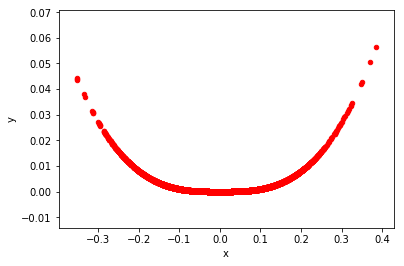

normal(0,0.1, size=10000)
efficienthoeffdingsD
10 loops, best of 3: 18.1 ms per loop
0.048069119935030255

Spearman
100 loops, best of 3: 8.76 ms per loop
spearman:           x         y
x  1.000000 -0.002044
y -0.002044  1.000000

Kendall
100 loops, best of 3: 2.73 ms per loop
Kendall:           x         y
x  1.000000  0.001095
y  0.001095  1.000000

normal(0,0.1, size=100000)
efficienthoeffdingsD
10 loops, best of 3: 170 ms per loop
0.10952612431294495

Spearman
10 loops, best of 3: 131 ms per loop
spearman:          x        y
x  1.00000 -0.00179
y -0.00179  1.00000

Kendall
10 loops, best of 3: 27.5 ms per loop
Kendall:           x         y
x  1.000000 -0.001369
y -0.001369  1.000000

normal(0,0.1, size=1000000)
efficienthoeffdingsD
1 loop, best of 3: 198 ms per loop
0.11271168535034062

Spearman
1 loop, best of 3: 2.17 s per loop
spearman:          x        y
x  1.00000 -0.00292
y -0.00292  1.00000

Kendall
1 loop, best of 3: 373 ms per loop
Kendall:           x         y
x  1.0

In [27]:
#Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation
print('Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation')

x=np.random.normal(0,0.1, size=10000)
y=abs(x*x*x) #(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y

df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

print('normal(0,0.1, size=10000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=100000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=100000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))


Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation


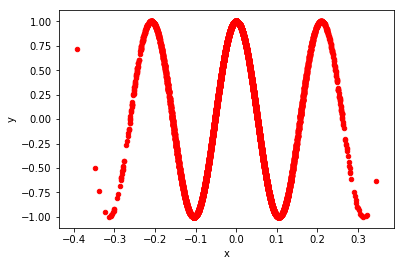

normal(0,0.1, size=10000)
efficienthoeffdingsD
10 loops, best of 3: 22.2 ms per loop
0.07741211995555954

Spearman
100 loops, best of 3: 8.88 ms per loop
spearman:           x         y
x  1.000000 -0.015771
y -0.015771  1.000000

Kendall
100 loops, best of 3: 2.89 ms per loop
spearman:           x         y
x  1.000000 -0.013052
y -0.013052  1.000000

normal(0,0.1, size=100000)
efficienthoeffdingsD
10 loops, best of 3: 175 ms per loop
0.15271297942651804

Spearman
10 loops, best of 3: 130 ms per loop
spearman:          x        y
x  1.00000  0.00263
y  0.00263  1.00000

Kendall
10 loops, best of 3: 25.9 ms per loop
spearman:           x         y
x  1.000000  0.002749
y  0.002749  1.000000

normal(0,0.1, size=1000000)
efficienthoeffdingsD
1 loop, best of 3: 193 ms per loop
0.1559146743794414

Spearman
1 loop, best of 3: 2.11 s per loop
spearman:           x         y
x  1.000000 -0.003069
y -0.003069  1.000000

Kendall
1 loop, best of 3: 338 ms per loop
spearman:           x         y

In [9]:
#Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation
print('Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation')

x=np.random.normal(0,0.1, size=10000)
y=(np.cos(30*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y

df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

print('normal(0,0.1, size=10000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=100000)
y=(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=100000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('Kendall:',df.corr('kendall'))


#Conclusion:
despite the pure python implementation, the execution time is kept to a reasonable value for smaller dataset.
If the dataset begins to be too large, undersampling and bining are applied on the inputs. The result of these approximation has a slight impact on the HoeffdingD value. however, it stays on the same range and are in line with the values return by software as JMP.

#Ways of improvment
- A smarter bining?
